<a href="https://colab.research.google.com/github/MorbidCuriosity84/DecisionTrees/blob/main/Coursework_2_Final(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**AI Coursework 2 - Decisions Tree Classifier**

**Mark Nelson - 40428606**

**WARNING: this will take roughly 15 minutes to run the complete notebook, as it is training several models.** 

**Please enable GPU hardware acceleration in colab before running.**

First I define all the functions needed to evaluate the dataset and any imports necessary as well as loading the data from the imdb dataset. 

In [2]:
import time
tic = time.perf_counter()
from keras.datasets import imdb
import numpy as np
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.util import ngrams
from nltk.util import bigrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from pprint import pprint


def extract_number_grams(sentences):
    tokens = []
    for sentence in sentences:
      tok = word_tokenize(sentence)
      for t in tok:
        tokens.append(t)
    return tokens    


def decode_dataset(dataset):
    decoded = [None] * dataset.size
    decoded = np.asarray(decoded)
    index = imdb.get_word_index()
    reverse_index = dict([(value, key) for (key, value) in index.items()])
    for j in range(dataset.size):
        temp = " ".join([reverse_index.get(i - 3, "#") for i in dataset[j]])
        temp = temp.replace("'", "")
        lemmatizer = WordNetLemmatizer() 
        lemmatized = " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(temp)]) 
        decoded[j] = lemmatized
    return decoded

def extract_bigrams(sentences): 

    all_bigrams = []
    for sentence in sentences:
      token = word_tokenize(sentence)
      bigrams = ngrams(token,2)
      for b in bigrams:
        all_bigrams.append(b)
    return all_bigrams


"""
def review_to_bow_array(reviews, vectoriser):
    bow_array = []
    for review in reviews:
        review_vector = vectoriser.transform(review)
        review_vector = review_vector.toarray()
        bow_array.append(review_vector)
    return bow_array
"""

(x_train, x_targets), (y_train, y_targets) = imdb.load_data()
tic1 = time.perf_counter()
toc1 = time.perf_counter()
print(f"Completed the code in {toc1 - tic:0.4f} seconds")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
17465344/17464789 [==============================] - 0s 0us/step
Completed the code in 10.4718 seconds


In [3]:
print(x_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


Next I decode the dataset, getting the words from the index values

In [4]:
tic2 = time.perf_counter()
x_train_words = decode_dataset(x_train)
y_train_words = decode_dataset(y_train)
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

1646592/1641221 [==============================] - 0s 0us/step
Completed the code in 99.3131 seconds


Now we start to analyse the dataset. First, finding the number of reviews in the training and testing dataset and then counting the number of words in each review and finding the average and standard deviation.

In [5]:
tic2 = time.perf_counter()
print("Number of unique words in training data: ")
print(len(np.unique(np.hstack(x_train_words))))
print()

print("Number of unique words in testing data: ")
print(len(np.unique(np.hstack(y_train_words))))
print()

print("Average review length:")
result = [len(x) for x in x_train_words]
print("Mean %.2f words, std_dev (%f)" % (np.mean(result), np.std(result)))
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

Number of unique words in training data: 
24902

Number of unique words in testing data: 
24801

Average review length:
Mean 1257.58 words, std_dev (950.838487)
Completed the code in 6.8947 seconds


We can see that the average review is around 1258 words in lenght with a standard deviation of 950 words. We could use this information to reduce the maximum size of reviews in order to lower the overheads of the algorithm. 95% of the reviews will fall below two standard deviations of the mean so a max length of 1258 + (2*950) would capture most reviews, discarding anything longer. As this is beyond the scope of this coursework we do not.

We then move on to extracting the unigrams and bigrams using nltk's ngram function. We use pprint to display the 20 most common unigrams and bigrams and their frequencies using nltk's FreqDist function.

In [6]:
tic2 = time.perf_counter()
unigrams = extract_number_grams(x_train_words)
bigrams = extract_bigrams(x_train_words)
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

Completed the code in 52.1703 seconds


In [7]:
tic2 = time.perf_counter()
unigram_freq_complete = nltk.FreqDist(unigrams)
pprint(unigram_freq_complete.most_common(20))
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

[('the', 336723),
 ('a', 210031),
 ('and', 164117),
 ('of', 145863),
 ('to', 135713),
 ('is', 107334),
 ('it', 104466),
 ('br', 101871),
 ('in', 94014),
 ('i', 77214),
 ('this', 76001),
 ('that', 69809),
 ('movie', 51704),
 ('wa', 48206),
 ('film', 47044),
 ('for', 44343),
 ('with', 44127),
 ('but', 42609),
 ('on', 34202),
 ('not', 31726)]
Completed the code in 5.0563 seconds


In [8]:
common_words = []
index = imdb.get_word_index()
reverse_index = dict([(value, key) for (key, value) in index.items()])
for i in range(20):
    temp = reverse_index[i+1]
    common_words.append(temp)
pprint(common_words)    

['the',
 'and',
 'a',
 'of',
 'to',
 'is',
 'br',
 'in',
 'it',
 'i',
 'this',
 'that',
 'was',
 'as',
 'for',
 'with',
 'movie',
 'but',
 'film',
 'on']


In [9]:
tic2 = time.perf_counter()
bigram_freq_complete = nltk.FreqDist(bigrams)
pprint(bigram_freq_complete.most_common(20))
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

[(('br', 'br'), 50966),
 (('of', 'the'), 39154),
 (('in', 'the'), 25214),
 (('this', 'movie'), 15771),
 (('the', 'film'), 13919),
 (('is', 'a'), 13672),
 (('and', 'the'), 13332),
 (('the', 'movie'), 12251),
 (('to', 'the'), 11994),
 (('to', 'be'), 11882),
 (('this', 'film'), 10944),
 (('it', 'is'), 10137),
 (('this', 'is'), 9477),
 (('on', 'the'), 8981),
 (('in', 'a'), 8956),
 (('it', 'wa'), 8542),
 (('one', 'of'), 8103),
 (('for', 'the'), 7998),
 (('with', 'the'), 7887),
 (('of', 'a'), 7869)]
Completed the code in 7.9566 seconds


As can be seen, both thses unigrams contain mostly stopwords or combinations of stopwords, plus linebreak (br). This is unsurprising as these stopwords are the most common words in the English language. We remove these stopwords and then perform the same analysis.

In [ ]:
tic2 = time.perf_counter()
from nltk.corpus import stopwords
nltk.download('stopwords')
pprint(stopwords.words('english'))
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

Looking at some of these words, it is clear that some might be worth including (but, not, nor) because they will change the meaning of the following word. We add br and # and remove the words we think will be useful to the classifier.

In [11]:
tic2 = time.perf_counter()
from nltk.corpus import stopwords
nltk.download('stopwords')
def remove_stop_words(reviews):
    stop_words = set(stopwords.words('english'))
    stop_words.add("br")  # adding line break
    stop_words.add("#")
    stop_words.add('im)')
    stop_words.remove('not')    # removes negation as this will change sentence meaning
    stop_words.remove('nor')    # removed because it can change meaning of following word 
    stop_words.remove('but')    
    minus_stop_words = [None] * reviews.size
    j = 0
    for review in reviews:
        review_tok = nltk.word_tokenize(str(review))
        temp_array = np.array([word for word in review_tok if word not in stop_words])
        minus_stop_words[j] = ' '.join(temp_array)
        j +=1
    return minus_stop_words

x_train_minus_stop = remove_stop_words(x_train_words)
unigrams_minus_stop = extract_number_grams(x_train_minus_stop)
bigrams_minus_stop = extract_bigrams(x_train_minus_stop)
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Completed the code in 63.2338 seconds


In [ ]:
tic2 = time.perf_counter()
unigram_freq = nltk.FreqDist(unigrams_minus_stop)
pprint(unigram_freq.most_common(20))
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

In [ ]:
tic2 = time.perf_counter()
bigram_freq = nltk.FreqDist(bigrams_minus_stop)
pprint(bigram_freq.most_common(20))
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

We create two visualisations of these unigrams. A graph of the logs of the frequencies and a word cloud.

In [ ]:
tic2 = time.perf_counter()
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def plot_freq(freq, title):
    plt.figure(figsize=(15, 7))
    f_array = list(freq.values())
    f_array.sort(reverse=True)
    dist = np.asarray(f_array)
    plt.plot(dist)
    plt.gca().set_xscale('log')
    plt.gca().set_yscale('log')
    plt.title(title)
    plt.xlabel('Rank')
    plt.ylabel('Number of occurrences')
    plt.grid()
    plt.show()

def plot_word_cloud(freq):
    wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate_from_frequencies(freq)    
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()


def plot_bigram_cloud_no_freq(bigram):
    joined_bigrams = join_bigrams(bigram)
    fdist = nltk.FreqDist(joined_bigrams)
    plot_word_cloud(fdist)

def join_bigrams(bigram):
    joined_bigrams = [None] * len(bigram)    
    for i in range(len(bigram)):
      joined_bigrams[i] = " ".join(bigram[i])
    return joined_bigrams


toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

In [ ]:
tic2 = time.perf_counter()
plot_word_cloud(unigram_freq)
plot_word_cloud(unigram_freq_complete)
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

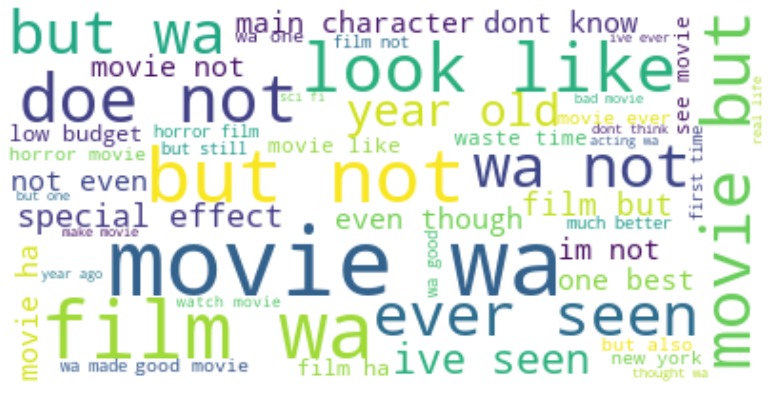

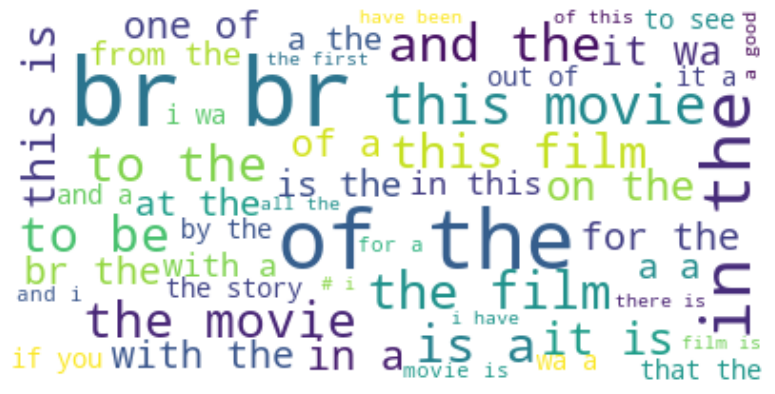

Completed the code in 13.3116 seconds


In [16]:
tic2 = time.perf_counter()
plot_bigram_cloud_no_freq(bigrams_minus_stop)
plot_bigram_cloud_no_freq(bigrams)
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

In [ ]:
tic2 = time.perf_counter()
plot_freq(unigram_freq, "Unigrams Log Frequency")
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

In [ ]:
tic2 = time.perf_counter()
plot_freq(bigram_freq, "Bigrams Log Frequency")
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

In [ ]:
tic2 = time.perf_counter()
y_train_minus_stop = remove_stop_words(y_train_words)
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

In [ ]:
tic2 = time.perf_counter()
def get_vector(vectorizer, data_train,data_target):
    x_bow = vectorizer.fit_transform(x_data)
    y_bow = vectorizer.transform(y_data)
    return x_bow, y_bow


toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

In [21]:
tic2 = time.perf_counter()
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
def fit_model(depth, criterio, vectorizer, x_data, y_data):    
    x_bow = x_data
    y_bow = y_data

    clf = DecisionTreeClassifier(criterion=criterio, max_depth=depth)
    fig = clf.fit(x_bow, x_targets)
    print(clf.score(x_bow, x_targets))
    print(clf.score(y_bow, y_targets))
    y_predict = clf.predict(y_bow)

    print(confusion_matrix(y_predict, y_targets))
    print(classification_report(y_predict, y_targets,target_names=['Neg','Pos'], digits=4))
    print(accuracy_score(y_predict, y_targets))
    return clf


toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

Completed the code in 0.0003 seconds


In [ ]:
tic2 = time.perf_counter()
from sklearn.tree import export_graphviz
import graphviz
from sklearn import tree
from IPython.display import Image  
import pydotplus
def draw_tree(clf, write_tree, draw_tree, filename, vectorizer):
    
    dot_data = tree.export_graphviz(clf,  
                    filled=True, 
                    rounded=True,
                    special_characters=True,
                    feature_names = vectorizer.get_feature_names(),
                    class_names=['Neg','Pos'])
    graph = pydotplus.graph_from_dot_data(dot_data)
    if draw_tree:
        display(graphviz.Source(dot_data))
    if write_tree:
        graph.write_png(filename)


toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

In [ ]:
tic2 = time.perf_counter()
unigrams_only_vec = CountVectorizer(ngram_range=(1,1), min_df=10)
bigrams_only_vec = CountVectorizer(ngram_range=(2,2), min_df=10)
trigrams_only_vec = CountVectorizer(ngram_range=(3,3), min_df=10)
unigrams_and_bigrams_vec = CountVectorizer(ngram_range=(1,2), min_df=10)
uni_bi_trigrams_vec = CountVectorizer(ngram_range=(1,3), min_df=10)
bi_trigrams_vec = CountVectorizer(ngram_range=(2,3), min_df=10)

stop_unigrams_only_vec = CountVectorizer(ngram_range=(1,1), min_df=10)
stop_bigrams_only_vec = CountVectorizer(ngram_range=(2,2), min_df=10)
stop_trigrams_only_vec = CountVectorizer(ngram_range=(3,3), min_df=10)
stop_unigrams_and_bigrams_vec = CountVectorizer(ngram_range=(1,2), min_df=10)
stop_uni_bi_trigrams_vec = CountVectorizer(ngram_range=(1,3), min_df=10)
stop_bi_trigrams_vec = CountVectorizer(ngram_range=(2,3), min_df=10)
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

In [ ]:
tic2 = time.perf_counter()
x_bow_uni_no_stop = unigrams_only_vec.fit_transform(x_train_minus_stop)
y_bow_uni_no_stop = unigrams_only_vec.transform(y_train_minus_stop)
x_bow_uni_bi_no_stop = unigrams_and_bigrams_vec.fit_transform(x_train_minus_stop)
y_bow_uni_bi_no_stop = unigrams_and_bigrams_vec.transform(y_train_minus_stop)
x_bow_uni_tri_no_stop = uni_bi_trigrams_vec.fit_transform(x_train_minus_stop)
y_bow_uni_tri_no_stop = uni_bi_trigrams_vec.transform(y_train_minus_stop)
x_bow_bi_no_stop = bigrams_only_vec.fit_transform(x_train_minus_stop)
y_bow_bi_no_stop = bigrams_only_vec.transform(y_train_minus_stop)
x_bow_tri_no_stop = trigrams_only_vec.fit_transform(x_train_minus_stop)
y_bow_tri_no_stop = trigrams_only_vec.transform(y_train_minus_stop)
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

In [ ]:
tic2 = time.perf_counter()
x_bow_uni_stop = stop_unigrams_only_vec.fit_transform(x_train_words)
y_bow_uni_stop = stop_unigrams_only_vec.transform(y_train_words)
x_bow_uni_bi_stop = stop_unigrams_and_bigrams_vec.fit_transform(x_train_words)
y_bow_uni_bi_stop = stop_unigrams_and_bigrams_vec.transform(y_train_words)
x_bow_uni_tri_stop = stop_uni_bi_trigrams_vec.fit_transform(x_train_words)
y_bow_uni_tri_stop = stop_uni_bi_trigrams_vec.transform(y_train_words)
x_bow_bi_stop = stop_bigrams_only_vec.fit_transform(x_train_words)
y_bow_bi_stop = stop_bigrams_only_vec.transform(y_train_words)
x_bow_tri_stop = stop_trigrams_only_vec.fit_transform(x_train_words)
y_bow_tri_stop = stop_trigrams_only_vec.transform(y_train_words)
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

In [ ]:
tic2 = time.perf_counter()
trigram_clf = fit_model(15,"gini",uni_bi_trigrams_vec,x_bow_uni_tri_no_stop, y_bow_uni_tri_no_stop)
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

In [ ]:
tic2 = time.perf_counter()
trigram_clf_5 = fit_model(5,"gini",uni_bi_trigrams_vec,x_bow_uni_tri_no_stop, y_bow_uni_tri_no_stop)
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

In [ ]:
tic2 = time.perf_counter()
bigram_clf = fit_model(15,'gini',unigrams_and_bigrams_vec,x_bow_uni_bi_no_stop, y_bow_uni_bi_no_stop)
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

In [ ]:
tic2 = time.perf_counter()
bigram_clf_5 = fit_model(5,'gini',unigrams_and_bigrams_vec,x_bow_uni_bi_no_stop, y_bow_uni_bi_no_stop)
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

In [ ]:
tic2 = time.perf_counter()
unigram_clf = fit_model(15,'gini',unigrams_only_vec,x_bow_uni_no_stop, y_bow_uni_no_stop)
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

In [ ]:
#tic2 = time.perf_counter()
#unigram_clf = fit_model(15,'gini',unigrams_only_vec,x_bow_uni_stop, y_bow_uni_stop)
#toc2 = time.perf_counter()
#print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

In [ ]:
tic2 = time.perf_counter()
unigram_clf_5 = fit_model(5,'gini',unigrams_only_vec,x_bow_uni_no_stop, y_bow_uni_no_stop)
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

In [ ]:
tic2 = time.perf_counter()
unigram_with_stop = fit_model(15,"gini",stop_unigrams_only_vec,x_bow_uni_stop,y_bow_uni_stop)
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

In [ ]:
tic2 = time.perf_counter()
uni_bigrams_with_stop5 = fit_model(15,"gini",unigrams_and_bigrams_vec,x_bow_uni_bi_stop,y_bow_uni_bi_stop)
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

In [ ]:
tic2 = time.perf_counter()
uni_bi_trigrams_with_stop5 = fit_model(15,"gini",uni_bi_trigrams_vec,x_bow_uni_tri_stop,y_bow_uni_tri_stop)
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

In [ ]:
tic2 = time.perf_counter()
def train_rfc(critrn, num_est, depth,x_data,y_data,vectorizer):
    from sklearn.ensemble import RandomForestClassifier
    rfc = RandomForestClassifier(n_estimators=num_est,criterion=critrn,max_depth=depth, n_jobs=-1)    
    x_bow = x_data
    y_bow = y_data
    rfc.fit(x_bow,x_targets)
    print("Training acc:", rfc.score(x_bow, x_targets), "\nValidation acc:", rfc.score(y_bow, y_targets))
    y_predict = rfc.predict(y_bow)
    print(confusion_matrix(y_predict, y_targets))
    print(classification_report(y_predict, y_targets,digits=4,target_names=['Neg','Pos']))
    print(accuracy_score(y_predict, y_targets))
    return rfc


def draw_rfc_tree(rfc,filename,show_tree,vectorizer):  
    dot_data = export_graphviz(rfc.estimators_[5],  
                    filled=True, 
                    rounded=True,
                    special_characters=True,
                    feature_names = vectorizer.get_feature_names(),
                    class_names=['Neg','Pos'])
    graph = pydotplus.graph_from_dot_data(dot_data)
    if show_tree:
        display(graphviz.Source(dot_data))
    #if write_tree:
    graph.write_png(filename)


toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

In [ ]:
tic2 = time.perf_counter()
rfc_unigram15 = train_rfc("entropy",100,15,x_bow_uni_no_stop,y_bow_uni_no_stop,unigrams_only_vec)
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

In [ ]:
tic2 = time.perf_counter()
rfc_unigram25 = train_rfc("gini",100,5,x_bow_uni_no_stop,y_bow_uni_no_stop,unigrams_only_vec)
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

In [ ]:
tic2 = time.perf_counter()
rfc_uni_bigram15 = train_rfc("gini",100,15,x_bow_uni_bi_no_stop,y_bow_uni_bi_no_stop,unigrams_and_bigrams_vec)
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

In [ ]:
tic2 = time.perf_counter()
rfc_uni_bi_trigram15 = train_rfc("gini",100,15,x_bow_uni_tri_no_stop,y_bow_uni_tri_no_stop,uni_bi_trigrams_vec)
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

In [ ]:
tic2 = time.perf_counter()
rfc_bigram_only15 = train_rfc("gini",100,15,x_bow_bi_no_stop,y_bow_bi_no_stop,bigrams_only_vec)
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

In [ ]:
tic2 = time.perf_counter()
rfc_trigram_only15 = train_rfc("gini",100,15,x_bow_tri_no_stop,y_bow_tri_no_stop,trigrams_only_vec)
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

In [ ]:
tic2 = time.perf_counter()
rfc_unigram_only15_stop = train_rfc("gini",100,15,x_bow_uni_stop,y_bow_uni_stop,stop_unigrams_only_vec)
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

In [ ]:
tic2 = time.perf_counter()
rfc_uni_bigram15_stop = train_rfc("gini",100,15,x_bow_uni_bi_stop,y_bow_uni_bi_stop,stop_unigrams_and_bigrams_vec)
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

In [ ]:
tic2 = time.perf_counter()
rfc_trigram_only15 = train_rfc("gini",100,15,x_bow_uni_tri_stop,y_bow_uni_tri_stop,stop_uni_bi_trigrams_vec)
toc2 = time.perf_counter()
print(f"Completed the code in {toc2 - tic2:0.4f} seconds")

In [ ]:
toc = time.perf_counter()
print(f"Completed the code in {toc - tic:0.4f} seconds")